# Experiment: Linear separability with random labels

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

import random

In [2]:
import os

# Where to store model files and results
BASE_PATH = "2026-01-07-linear-separability-with-random-labels"
os.makedirs(BASE_PATH, exist_ok=True)

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device', DEVICE)

Using device cuda


## Load and preprocess CIFAR-10 data

In [3]:
class RandomizedDataset(Dataset):
    def __init__(self, base_dataset, random_seed=None):
        self.base_dataset = base_dataset
        self.random_seed = random_seed
        self.rng = random.Random(self.random_seed)
        self.new_labels = None

    def randomize_labels(self, p):
        labels = [y for x, y in self.base_dataset]
        self.random_label_p = p
        self.new_labels = [
            self.rng.choice(labels) if self.rng.random() < p else y
            for x, y in self.base_dataset
        ]
    
    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        x, y = self.base_dataset[idx]
        if self.new_labels is not None:
            y = self.new_labels[idx]
        return x, y

In [4]:
# Transformations for the training and test sets
class PerImageStandardize:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # x: Tensor [C, H, W] in float
        mean = x.mean()
        std = x.std().clamp_min(1.0 / (x.numel() ** 0.5))
        x = (x - mean) / std
        return x


transform_data = transforms.Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor(),  # Changes shape from (height, width, channels) to (channels, height, width).
    PerImageStandardize(),
])

train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_data
)

test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_data
)

print(f"Number of training samples: {len(train_set)}")
print(f"Number of test samples: {len(test_set)}")

100%|██████████| 170M/170M [00:02<00:00, 75.6MB/s] 


Number of training samples: 50000
Number of test samples: 10000


## Model: AlexNet

Note: I started this experiment with AlexNet, but did not find anything interesting — after 100 epochs of training, the network had not made only very little progress on memorizing the data set (training accuracy at 11% after 100 epochs vs 10% at the start). I switched to the small AlexNet model below since I know that memorizes randomly labelled data after 100 epochs from the [Zhang 2016 reproduction](2025-12-21-reproduce-zhang-2017-understanding.ipynb).

In [5]:
class AlexNet(nn.Module):
    name = 'alexnet'
    
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),

            nn.Conv2d(128, 192, kernel_size=3, padding=1),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.Conv2d(192, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc_layers(x)
        return x

In [6]:
class AlexNetSmall(nn.Module):
    name = 'alexnetsmall'

    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(7 * 7 * 128, 384),
            nn.ReLU(),
            nn.Linear(384, 192),
            nn.ReLU(),
            nn.Linear(192, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc_layers(x)
        return x

## Training

In [18]:
# Set this to True to retrain the base AlexNet model, before attaching
# linear probes to it.
RETRAIN = True

In [19]:
def train_one_epoch(model, train_loader, loss_function, optimizer, scheduler):
    '''
    Handle a single training pass, including forward and backward propagation,
    loss calculation, gradient optimization, and accumulation of training metrics.
    '''
    # Set the model to training mode
    model.train()
    # Initialize metrics
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in train_loader:
        # Load data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Update training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    scheduler.step()
    # Return average metrics
    epoch_loss = running_loss / total_samples
    epoch_accuracy = 100 * correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

In [20]:
def evaluate_model(model, data_loader, loss_function):
    '''
    Place the model in evaluation mode, disable gradient calculations,
    and compute average loss and accuracy on a given dataset.
    '''
    model.eval()  # Set the model to evaluation mode

    # Init metrics
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient calculations, i.e. freeze the model parameters
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / total_samples
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [24]:
def train_model(model, batch_size = 128, num_workers = None, num_epochs = 100, save_state = True, overwrite = False):
    '''
    Setup data loaders, model, and optimizer. Then, orchestrate model training
    over multiple epochs, calling `train_one_epoch` and `evaluate_model` to
    track both training and validation performance.
    '''
    import torch.optim as optim
    from torch.optim.lr_scheduler import ExponentialLR

    if num_workers is None:
        if str(DEVICE) == 'cuda':
            num_workers = 4
        else:
            num_workers = 0
    print('Num workers:', num_workers)
    
    train_set_randomized = RandomizedDataset(train_set, random_seed=123)
    train_set_randomized.randomize_labels(p=1)
    train_loader = DataLoader(train_set_randomized, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    validation_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    model.to(DEVICE)
    
    # Choose the loss function: cross-entropy loss for classification task
    loss_function = nn.CrossEntropyLoss()
    
    # Choose the optimizer, for example `Adam` or `SGD` with appropriate learning rate.
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = ExponentialLR(optimizer, gamma=0.95)
    
    def _save_state(epoch):
        nonlocal model, save_state, overwrite
        if not save_state:
            return
        path = os.path.join(BASE_PATH, f"{model.name}-epoch-{epoch:03d}.pt")
        try:
            open(path, 'r')
        except FileNotFoundError:
            pass
        else:
            if not overwrite:
                import errno
                raise FileExistsError(
                    errno.EEXIST,
                    "File already exists (and overwrite not allowed)",
                    path,
                )
        torch.save(model.state_dict(), path)

    _save_state(epoch=0)
    print("Starting training...")
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'validation_loss': [],
        'validation_accuracy': [],
    }
    try:
        for epoch in range(num_epochs):
            train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_function, optimizer, scheduler)
            validation_loss, validation_accuracy = evaluate_model(model, validation_loader, loss_function)
            _save_state(epoch=epoch + 1)
            history['train_loss'].append(train_loss)
            history['train_accuracy'].append(train_accuracy)
            history['validation_loss'].append(validation_loss)
            history['validation_accuracy'].append(validation_accuracy)
            print(f"Completed epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")
    except KeyboardInterrupt:
        print('Interrupted')

    print("Training finished.")
    return history

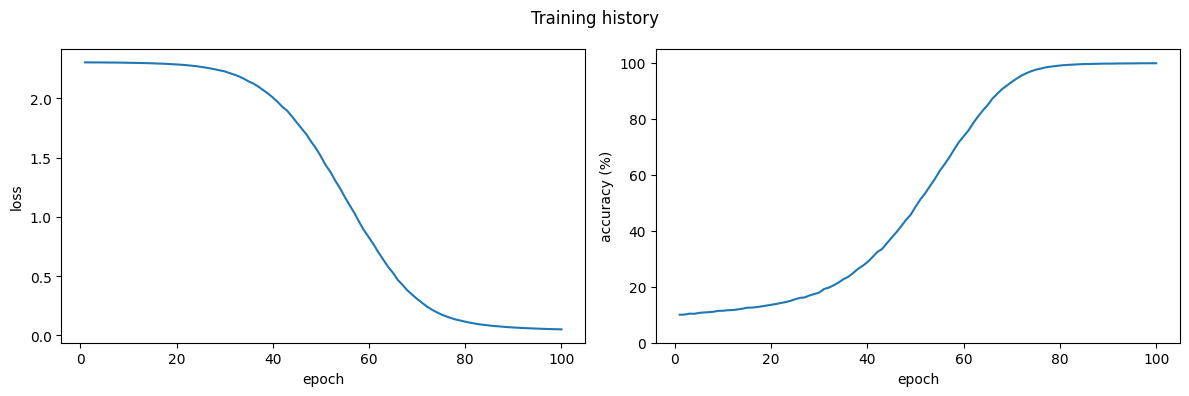

In [27]:
num_training_epochs = 100
if RETRAIN:
    model = AlexNetSmall()
    training_history = train_model(model, num_epochs=num_training_epochs, overwrite=True)
    
    # Plot training history
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 4))
    plt.suptitle('Training history')
    plt.subplot(1, 2, 1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plot_epochs = list(range(1, len(training_history['train_loss']) + 1))
    plt.plot(plot_epochs, training_history['train_loss'])

    plt.subplot(1, 2, 2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy (%)')
    plt.plot(plot_epochs, training_history['train_accuracy'])
    plt.ylim(0, 105)
    
    plt.tight_layout()
    plt.show()

## Linear probe

* Load model state
* Do surgery to install a linear probe
* Optimize the probe
* Evaluate validation accuracy

In [28]:
def load_model(model_class, epoch):
    model = model_class()
    path = os.path.join(BASE_PATH, f"{model.name}-epoch-{epoch:03d}.pt")
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint)
    model.to(DEVICE)
    return model

In [29]:
class SurgeryModel(nn.Module):
    def __init__(self, backbone, tapped_layer_name):
        super().__init__()
        self.backbone = backbone
        self.tapped_layer_name = tapped_layer_name
        self.activation = {}

        # Install hook
        tapped_layer = dict(self.backbone.named_modules())[tapped_layer_name]
        tapped_layer.register_forward_hook(self._hook)

        # Infer number of classes
        m = list(backbone.modules())[-1]
        if not isinstance(m, torch.nn.Linear):
            raise TypeError("Expected the final layer of `backbone` to be torch.nn.Linear")
        self.num_classes = m.out_features

        # Placeholder; set after we see data once
        self.head = None

    def _hook(self, module, inp, out):
        self.activation[self.tapped_layer_name] = out

    def _init_head_if_needed(self):
        if self.head is not None:
            return
        feat = self.activation[self.tapped_layer_name]
        if feat.dim() == 4:  # [B, C, H, W]
            # Convolutional layer: flatten before attaching linear layer
            c = feat.shape[1]
            self.head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(c, self.num_classes),
            )
        else:  # [B, D]
            d = feat.shape[1]
            self.head = nn.Linear(d, self.num_classes)
        self.head = self.head.to(feat.device)

    def forward(self, x):
        _ = self.backbone(x)
        self._init_head_if_needed()
        feat = self.activation[self.tapped_layer_name]
        return self.head(feat)

In [30]:
# Probe each layer in order. We expect classes to be progressively more linearly
# separable as we go deeper into the network. Note that probing layer X means attaching
# the probe to the output of X.
def iter_leaf_modules_in_tree_order(model: nn.Module):
    for name, m in model.named_modules():
        if name == "":
            continue  # skip the root module itself
        if len(list(m.children())) == 0:  # leaf = no submodules
            yield name, m

In [ ]:
num_epochs = 10  # Number of epochs for probe optimization

# These parameters are the same as the ones used during training of the original model
batch_size = 128
if str(DEVICE) == 'cuda':
    num_workers = 4
else:
    num_workers = 0

# Save probe results to CSV. Create the file if it does not exist,
# otherwise append to the existing file
import csv
csv_filename = os.path.join(BASE_PATH, "probe-results.csv")
try:
    with open(csv_filename, 'r') as fp:
        pass
except FileNotFoundError:
    write_header = True
else:
    write_header = False
csv_file = open(csv_filename, 'at')
csv_writer = csv.writer(csv_file)
if write_header:
    csv_writer.writerow(['training epochs', 'probe layer index', 'probe layer name', 'validation loss', 'validation accuracy'])

for training_epoch in [0, 3, 6, 12, 18, 25, 37, 50, 75, 100]:
    original_model = load_model(AlexNetSmall, training_epoch)
    print(f"\nProbing all layers for training epoch {training_epoch} in order.")
    print("Probing layer X means attaching the linear probe to the output of X.")
    
    for probe_layer_index, (probe_layer, probe_module) in enumerate(iter_leaf_modules_in_tree_order(original_model)):
        print(f"Probing {probe_layer}:", probe_module)
    
        # Create probed model; freeze non-probe weights
        model_with_probe = SurgeryModel(original_model, probe_layer)
        for p in model_with_probe.backbone.parameters():
            p.requires_grad = False
    
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        validation_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
            
        model_with_probe.to(DEVICE)
            
        loss_function = nn.CrossEntropyLoss()
        
        # Init optimizer; requires initializing the surgery model with a dummy input
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 28, 28, device=DEVICE)
            out = model_with_probe(dummy)
            num_classes = out.shape[1]
        optimizer = torch.optim.SGD(model_with_probe.head.parameters(), lr=0.01, momentum=0.9)
        
        from torch.optim.lr_scheduler import ExponentialLR
        scheduler = ExponentialLR(optimizer, gamma=0.95)
    
        # Optional sanity check: record weights to make sure they remain frozen
        SANITY_CHECK = False
        if SANITY_CHECK:
            import copy
            _weights_before = {
                name: p.detach().clone()
                for name, p in model_with_probe.named_parameters()
            }
        
        for epoch in range(num_epochs):
            train_loss, train_accuracy = train_one_epoch(model_with_probe, train_loader, loss_function, optimizer, scheduler)
        validation_loss, validation_accuracy = evaluate_model(model_with_probe, validation_loader, loss_function)
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")
    
        if SANITY_CHECK:
            print('  weight change sanity check:')
            for name, p in model_with_probe.named_parameters():
                print(f"   - {name}:", 'same' if torch.equal(_weights_before[name], p) else 'CHANGED')

        csv_writer.writerow([training_epoch, probe_layer_index, probe_layer, validation_loss, validation_accuracy])
        csv_file.flush()

    del original_model

## Plot linear probe results

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Read CSV
df = pd.read_csv(os.path.join(BASE_PATH, "probe-results.csv"))

'''
# Name the layers for the x-axis labels (AlexNet)
nn_layers = [
    'Conv2d', 'ReLU', 'MaxPool2d', 'LocalResponseNorm',
    'Conv2d', 'ReLU', 'MaxPool2d', 'LocalResponseNorm',
    'Conv2d', 'Conv2d', 'Conv2d', 'ReLU', 'MaxPool2d',
    'Linear', 'ReLU', 'Linear', 'ReLU', 'Linear',
]
'''

# Name the layers for the x-axis labels (AlexNetSmall)
nn_layers = [
    'Conv2d', 'ReLU', 'MaxPool2d', 'LocalResponseNorm',
    'Conv2d', 'ReLU', 'MaxPool2d', 'LocalResponseNorm',
    'Linear', 'ReLU', 'Linear', 'ReLU', 'Linear',
]

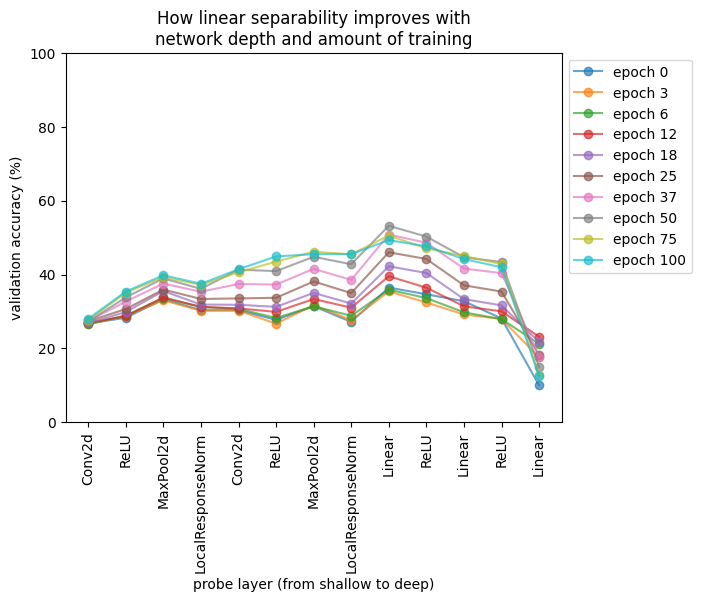

In [6]:
plt.figure()
plt.title("How linear separability improves with\nnetwork depth and amount of training")
plt.xlabel("probe layer (from shallow to deep)")
plt.ylabel("validation accuracy (%)")

for epoch in [0, 3, 6, 12, 18, 25, 37, 50, 75, 100]:
    df_filt = df[df["training epochs"] == epoch]
    plt.plot(df_filt["probe layer index"], df_filt["validation accuracy"], 'o-', label=f"epoch {epoch}", alpha=0.667)
plt.xticks(range(len(nn_layers)), nn_layers, rotation=90)
plt.ylim(0, 100)
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.show()

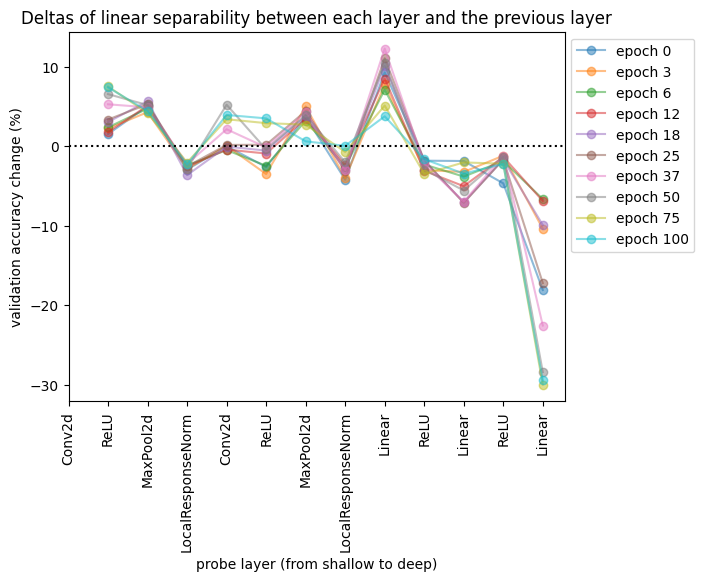

In [7]:
plt.figure()
plt.title("Deltas of linear separability between each layer and the previous layer")
plt.xlabel("probe layer (from shallow to deep)")
plt.ylabel("validation accuracy change (%)")

for epoch in [0, 3, 6, 12, 18, 25, 37, 50, 75, 100]:
    df_filt = df[df["training epochs"] == epoch]
    plt.plot(
        df_filt["probe layer index"].array[1:],
        df_filt["validation accuracy"].array[1:] - df_filt["validation accuracy"].array[:-1],
        'o-', label=f"epoch {epoch}", alpha=0.5)
plt.xticks(range(len(nn_layers)), nn_layers, rotation=90)
plt.axhline(0, linestyle=':', color='k')
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.show()

## Interesting features

* Attempting this on the larger AlexNet model didn't really get anywhere after 100 epochs of training. The training accuracy was improving but very slowly, from about 10% at the start to about 11% after 100 epochs. It's conceivable that the network would ultimately be able to memorize the training data set with random labels, but the signal to noise ratio from the randomized labels is clearly too low.
* On the AlexNetSmall model, we see that the convolutional layers develop progressively better representations, leading to more linear separability an the classification labels, as we train more — even though training happened on random labels! So, there was no signal from the classification task (random) to help the convolutional layers develop good representations. Even though it essentially has to memorize the training data set, to achive ~100% accuracy after 100 epochs of training, it is still useful to develop reusable representations to help with this memorization tasks. The representations are reusable in the sense that they improve classification accuracy on the original task, with the given, unrandomized class labels.
* The first convolutional layer converges before the second convolutional layer. After about 37 training epochs, the first convolutional layer stops improving in terms of linear separability, but the second layer still improves up to about 75 training epochs.
* The fully connected layers are not ever very useful — adding more than the first fully connected layer (without the ReLU) always decreases linear separability. I'm not sure why the first layer improves it — my best guess at the moment is that it behaves like a random up-projection, which has the well-known property of increasing linear separability.
* [As before](2026-01-07-train-and-compare-modified-alexnet), the local response norm layers are always detrimental and should probably be removed.
  * Update: See [2026-01-09-linear-separability-with-random-labels-sans-local-response-norm](2026-01-09-linear-separability-with-random-labels-sans-local-response-norm.ipynb) for a copy of this notebook with the local response norm layers removed. It now memorizes the training data in fewer than 50 epochs rather than 100. There is other weird behavior though — the second convolutional layer does worse than before.

## New hypotheses:

* Using automatically labelled (but not randomly labelled) training data will work even better (better accuracy; fewer training epochs required), even on the larger AlexNet model. If we create labels that are easy to compute directly from the image data, those labels will provide a much better signal-to-noise ratio for network training, allowing it to develop useful representations faster. Those representations will also be useful for the original classification task, as measured by linear separability using linear probes.
  * Open question: Which automatically generated labels work the best? Examples: dominant colour(s), dominant orientation(s), dominant frequency(-ies) in the image. Perhaps noisily supervised labels (for example, extracting labels from captions or similar context around an image) would be even better, and also cheap to get. Need to investigate which other labels can be computed directly from the image data.